# Dyna: Integrating Learning and Planning

Mario Fiorino

$\;$


Premesse


$\;$


**Modello**


Un modello dell'ambiente rappresenta uno strumento mediante il quale un agente  può prevedere come l'ambiente risponderà a una sua specifica azione.
In pratica, nel caso deterministico, il modello è una funzione che associa ad ogni coppia stato-azione, uno stato successivo e la conseguente ricompensa.

Nel caso in cui il modello sia di natura stocastica, per ogni coppia stato-azione, ci sono diverse opzioni per gli stati successivi e relative ricompense, ciascuna opzione con una specifica probabilità di verficarsi.


**Distribution models** :  i modelli che forniscono una descrizione completa di tutte le opzioni, e la loro probabilità di verificarsi. Questo è il tipo di modello usato nella programmazione dinamica.

**Sample models**:  i modelli che generano una delle possibili opzioni (un campione), selezionata in accordo alle probabilità del sistema. (non forniscono una descrizione probabilistica esaustiva, ma generano solo campioni; come esempio vedi notebook precedenti, l'ambinete Blackjack di Gym )

I modelli possono essere utilizzati per replicare o simulare l'esperienza. Dato uno stato iniziale e un'azione: un *sample models* crea una transizione possibile, mentre un *distribution models* genera tutte le transizioni possibili, assegnando loro un peso in base alla loro probabilità di verificarsi.

Se disponiamo di uno stato iniziale e di una politica (ovvero un insieme di regole decisionali), un *sample models* potrebbe generare un episodio completo, mentre un *distribution models* sarebbe in grado di generare tutti gli episodi possibili, ciascuno con la sua probabilità associata.


$\;$

**Planning**

Nel contesto di RL, la "pianificazione" o planning, si riferisce a qualsiasi processo computazionale che riceve in input un modello dell'ambiente, ed in uscita, produce o migliora una politica.

Lo *State-space planning* è un metodo che concepisce la pianificazione come una ricerca attraverso lo spazio degli stati per individuare una politica ottimale o un percorso ottimale verso un obiettivo. Le azioni generano transizioni da uno stato all'altro, e le funzioni di valore vengono calcolate sui singoli stati.

$\;$


**DYNA**

Dyna è un algoritmo che integra metodi di pianificazione e il direct RL (o RL classico):

- Il metodo *Direct RL* consiste nel migliorare la value function e la politica utilizzando l'esperienza reale ottenuta dall'interazione dell'agente con l'ambiente.
Allo stesso tempo, tramite l'esperienza reale ottenuta, l’algoritmo apprende o migliora anche il modello ambientale (*Model learning*),

- Nella fase di *Planning*, si utilizza il modello appreso, producendo Simulated experience, per assistere l'agente nella ricerca di una politica ottimale.

Buono a sapersi: per quello che concerne la fase di Model learning, un modello complesso si può apprendere in modo efficiente mediante i metodi di supervised learning.

$\;$

Ref

Reinforcement Learning: An Introduction

Chapter 8.1,8.2, 8.3, 8.4, 8.13

Richard S. Sutton and Andrew G. Barto, Second Edition - MIT Press, Cambridge, 2018.

$\;$

RL Course by David Silver, L8

https://www.youtube.com/watch?v=ItMutbeOHtc&t


<div>
<img src="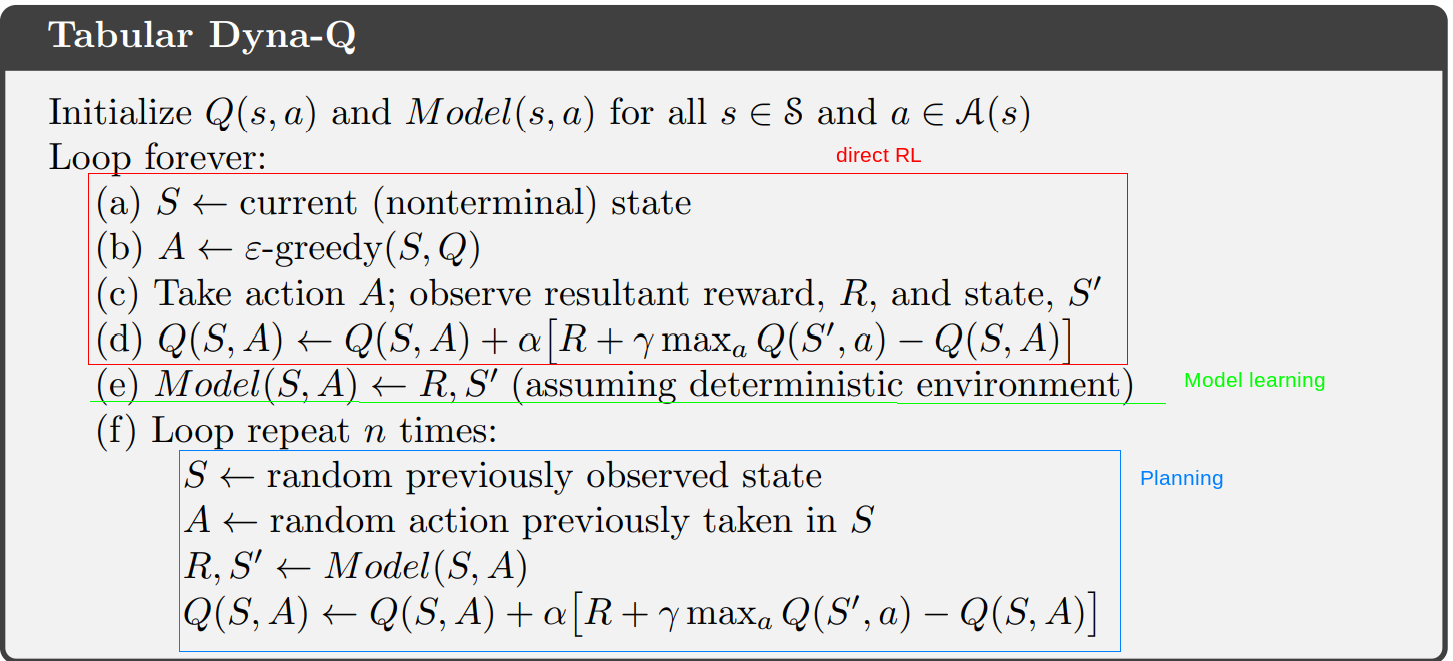
", width="600">
</div>

## Tabular Dyna-Q coding


Sviluppo ispirato all'Example 8.1: Dyna Maze. PDF 186

Labirinto di 47 stati disponibili

Quattro azioni: su, giù, destra e sinistra. Queste azioni spostano l'agente in modo deterministico verso gli stati adiacenti corrispondenti, a meno che il movimento non sia bloccato da un ostacolo o dal bordo del labirinto. In questi casi, l'agente rimane dov'è.

La ricompensa è zero per tutte le transizioni (spostamenti), tranne quelle che portano allo stato terminale G, dove la ricompensa è +10. Nota: vi è un solo stato terminale, G, questo significa che tutti gli episodi terminano con un reward. Dopo aver raggiunto lo stato G, l'agente ritorna allo stato iniziale (S) per iniziare un nuovo episodio

In [ ]:
# il codice sottostante prende ispirazione dal lavoro:
# https://github.com/MJeremy2017/reinforcement-learning-implementation/blob/master/DynaMaze/DynaMaze.ipynb

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import collections

ROWS = 6
COLS = 9
S = (2, 0)
G = (0, 8)
BLOCKS = [(1, 2), (2, 2), (3, 2), (0, 7), (1, 7), (2, 7), (4, 5)]
ACTIONS = ["left", "up", "right", "down"]


In [ ]:
# Ambiente

class Maze:

    def __init__(self):
        self.rows = ROWS
        self.cols = COLS
        self.start = S
        self.goal = G
        self.blocks = BLOCKS
        self.state = S
        self.end = False
        # init maze
        self.maze = np.zeros((self.rows, self.cols))
        for b in self.blocks:
            self.maze[b] = -1

    def nxtPosition(self, action):
        r, c = self.state
        if action == "left":
            c -= 1
        elif action == "right":
            c += 1
        elif action == "up":
            r -= 1
        else:
            r += 1

        if (r >= 0 and r <= self.rows-1) and (c >= 0 and c <= self.cols-1):
            if (r, c) not in self.blocks:
                self.state = (r, c)
        return self.state

    def giveReward(self):
        if self.state == self.goal:
            self.end = True
            return 10
        else:
            return 0

    def showMaze(self):
        self.maze[self.state] = 1
        for i in range(0, self.rows):
            print('-------------------------------------')
            out = '| '
            for j in range(0, self.cols):
                if self.maze[i, j] == 1:
                    token = '$'
                if self.maze[i, j] == -1:
                    token = 'X'
                if self.maze[i, j] == 0:
                    token = '.'
                if i ==0 and j == 8:
                    token = 'G'
                out += token + ' | '
            print(out)
        print('-------------------------------------')



In [ ]:
# é stato usato un array numpy,
# dove X indica il muro di blocco,
# $ indica la posizione attuale dell'agente
# . indica i posti vuoti e disponibili.
# G indica la posizione finale con reward +1

m = Maze()
m.showMaze()

-------------------------------------
| . | . | . | . | . | . | . | X | G | 
-------------------------------------
| . | . | X | . | . | . | . | X | . | 
-------------------------------------
| $ | . | X | . | . | . | . | X | . | 
-------------------------------------
| . | . | X | . | . | . | . | . | . | 
-------------------------------------
| . | . | . | . | . | X | . | . | . | 
-------------------------------------
| . | . | . | . | . | . | . | . | . | 
-------------------------------------


In [ ]:
# Premessa tecnica per comprendere l'implementazione di Planning della class DynaAgent

model_d = {(2, 0): {'down': (0, (3, 0)), 'up': (0, (1, 0)), 'right': (0, (2, 1)), 'left': (0, (2, 0))}, (3, 0): {'left': (0, (3, 0)), 'down': (0, (4, 0)), 'right': (0, (3, 1)), 'up': (0, (2, 0))} }

print(list(model_d))
print(list(model_d)[1])

print(list(model_d[(3, 0)]))
print(list(model_d[(3, 0)])[3])

print(model_d[(3, 0)]['right']) #  _reward, _nxtState

[(2, 0), (3, 0)]
(3, 0)

['left', 'down', 'right', 'up']
up

(0, (3, 1))


In [ ]:

class DynaAgent:

    # nella funzione __init__ inizializzeremo tutti i parametri necessari per l'algoritmo
    def __init__(self, exploration_rate=0.2, alpha=0.1, gamma = 0.95, n_steps=0, episodes=30):
        self.maze = Maze()
        self.state = S
        self.actions = ACTIONS
        self.state_actions = []  # state & action track
        self.exploration_rate = exploration_rate
        self.lr = alpha
        self.gamma = gamma

        self.steps_planning = n_steps
        self.episodes = episodes  # number of episodes going to play
        self.steps_per_episode = []

        self.Q_values = {}
        # model function
        self.model = {}
        for row in range(ROWS):
            for col in range(COLS):
                self.Q_values[(row, col)] = {}
                for a in self.actions:
                    self.Q_values[(row, col)][a] = 0


# l'agente ha probabilità "self.exploration_rate" di intraprendere un'azione casuale non greedy,
# e probabilità "1 — self.exploration_rate" di intraprendere un'azione greedy rispetto Q
    def chooseAction(self):

        # epsilon-greedy
        mx_nxt_reward = -999
        action = ""

        current_position = self.state

        # if all actions have same value, then select randomly
        if len(set(self.Q_values[current_position].values())) == 1:
            action = np.random.choice(self.actions)

        else:
            # Find the greedy action
            for a in self.actions:
                nxt_reward = self.Q_values[current_position][a]
                if nxt_reward >= mx_nxt_reward:
                        action = a
                        mx_nxt_reward = nxt_reward

        #exploration phase
        if np.random.uniform(0, 1) <= self.exploration_rate:
            sup_a = self.actions.copy()
            sup_a.remove(action)
            action = np.random.choice(sup_a)

        return action


    def reset(self):
        self.maze = Maze()
        self.state = S
        self.state_actions = []


#  Tabular Dyna-Q

    def play(self):

        self.steps_per_episode = []

        for ep in range(1, self.episodes+1):

            while not self.maze.end:

                action = self.chooseAction()  # epsilon-greedy
                self.state_actions.append((self.state, action))

                nxtState = self.maze.nxtPosition(action)
                reward = self.maze.giveReward()


                # update Q-value - direct RL
                self.Q_values[self.state][action] =self.Q_values[self.state][action] + self.lr*(reward + self.gamma * np.max(list(self.Q_values[nxtState].values())) - self.Q_values[self.state][action])

                if ep > 0 and ep % (self.episodes/3) == 0 and reward > 0:
                   print("Episode : ",ep )
                   print(" End of Direct RL ")
                   res = collections.OrderedDict(sorted(self.model.items()))
                   print("Model learned: ", res)
                   res1 = collections.OrderedDict(sorted(self.Q_values.items()))
                   print("Q_value: ", res1)


                # update model
                if self.state not in self.model.keys():
                    self.model[self.state] = {}
                self.model[self.state][action] = (reward, nxtState)

                self.state = nxtState

                # Planning loop:
                # randomly choose state-action, and, update Q-value

                for _ in range(self.steps_planning):

                    # randomly choose an state
                    rand_idx = np.random.choice(range(len(self.model.keys())))
                    _state = list(self.model)[rand_idx]

                    # randomly choose an action
                    rand_idx = np.random.choice(range(len(self.model[_state].keys())))
                    _action = list(self.model[_state])[rand_idx]

                    _reward, _nxtState = self.model[_state][_action]

                    # update Q-value - planning phase
                    self.Q_values[_state][_action] = self.Q_values[_state][_action] + self.lr*(_reward + self.gamma * np.max(list(self.Q_values[_nxtState].values())) - self.Q_values[_state][_action])

            # end of episode

            if ep > 0 and ep % (self.episodes/3) == 0:
                   print("End of Planning")
                   res3 = collections.OrderedDict(sorted(self.Q_values.items()))
                   print("Q_value: ", res3)
                   print("\n")

            self.steps_per_episode.append(len(self.state_actions))
            self.reset()

Si noti che all'interno del loop del Planning lo stato (_state) e l'azione (_action) sono entrambi selezionati casualmente dalle osservazioni precedenti.


Il modello (self.model) parte da un dizionario vuoto, che si riempie durante il susseguirsi degli step. Nel nostro esempio, in genere già dopo i primi due o tre episodi, la totalità delle coppie stato-azione dell'ambiente sono state "modellizzate".



In [ ]:
agent = DynaAgent(n_steps=0)
agent.play()

steps_episode_0 = agent.steps_per_episode
print(steps_episode_0)

Episode :  10
 End of Direct RL 
Model learned:  OrderedDict([((0, 0), {'down': (0, (1, 0)), 'left': (0, (0, 0)), 'up': (0, (0, 0)), 'right': (0, (0, 1))}), ((0, 1), {'left': (0, (0, 0)), 'down': (0, (1, 1)), 'up': (0, (0, 1)), 'right': (0, (0, 2))}), ((0, 2), {'left': (0, (0, 1)), 'down': (0, (0, 2)), 'up': (0, (0, 2)), 'right': (0, (0, 3))}), ((0, 3), {'up': (0, (0, 3)), 'down': (0, (1, 3)), 'left': (0, (0, 2)), 'right': (0, (0, 4))}), ((0, 4), {'down': (0, (1, 4)), 'left': (0, (0, 3)), 'up': (0, (0, 4)), 'right': (0, (0, 5))}), ((0, 5), {'down': (0, (1, 5)), 'left': (0, (0, 4)), 'right': (0, (0, 6)), 'up': (0, (0, 5))}), ((0, 6), {'up': (0, (0, 6)), 'down': (0, (1, 6)), 'left': (0, (0, 5)), 'right': (0, (0, 6))}), ((1, 0), {'up': (0, (0, 0)), 'left': (0, (1, 0)), 'down': (0, (2, 0)), 'right': (0, (1, 1))}), ((1, 1), {'down': (0, (2, 1)), 'up': (0, (0, 1)), 'left': (0, (1, 0)), 'right': (0, (1, 1))}), ((1, 3), {'left': (0, (1, 3)), 'up': (0, (0, 3)), 'down': (0, (2, 3)), 'right': (0,

In [ ]:
agent = DynaAgent(n_steps=20)
agent.play()

steps_episode_20 = agent.steps_per_episode
print(steps_episode_20)

Episode :  10
 End of Direct RL 
Model learned:  OrderedDict([((0, 0), {'left': (0, (0, 0)), 'right': (0, (0, 1)), 'down': (0, (1, 0)), 'up': (0, (0, 0))}), ((0, 1), {'right': (0, (0, 2)), 'down': (0, (1, 1)), 'up': (0, (0, 1)), 'left': (0, (0, 0))}), ((0, 2), {'up': (0, (0, 2)), 'down': (0, (0, 2)), 'right': (0, (0, 3)), 'left': (0, (0, 1))}), ((0, 3), {'up': (0, (0, 3)), 'right': (0, (0, 4)), 'left': (0, (0, 2)), 'down': (0, (1, 3))}), ((0, 4), {'left': (0, (0, 3)), 'down': (0, (1, 4)), 'up': (0, (0, 4)), 'right': (0, (0, 5))}), ((0, 5), {'left': (0, (0, 4)), 'right': (0, (0, 6)), 'down': (0, (1, 5))}), ((0, 6), {'right': (0, (0, 6)), 'up': (0, (0, 6)), 'down': (0, (1, 6)), 'left': (0, (0, 5))}), ((1, 0), {'left': (0, (1, 0)), 'up': (0, (0, 0)), 'right': (0, (1, 1)), 'down': (0, (2, 0))}), ((1, 1), {'left': (0, (1, 0)), 'down': (0, (2, 1)), 'right': (0, (1, 1)), 'up': (0, (0, 1))}), ((1, 3), {'up': (0, (0, 3)), 'left': (0, (1, 3)), 'right': (0, (1, 4))}), ((1, 4), {'down': (0, (2, 4)

Confrontiamo il processo di apprendimento in base al numero di step di planning utilizzati.

Primo caso: $n = 0$, non usiamo procedimenti di planning.

Secondo caso abbiano una fase di planning di $n = 20$ steps.

Nel grafico, sull'asse $x$ è il numero di episodi, e sull'asse $y$ è il numero di step nella fase di direct RL,  per raggiungere l'obiettivo per ogni episodio.

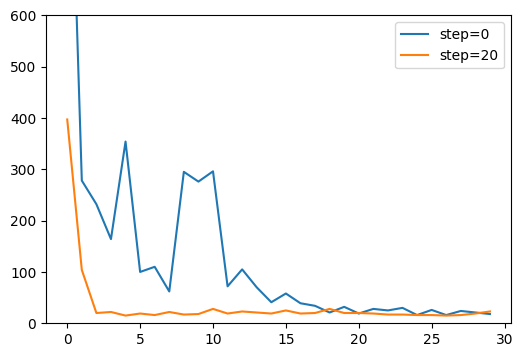

In [ ]:
plt.figure(figsize=[6, 4])

plt.ylim(0, 600)
plt.plot(range(30), steps_episode_0, label="step=0")
plt.plot(range(30), steps_episode_20, label="step=20")


plt.legend()

Vantaggi


La metodologia Dyna può essere utile in ambienti complessi, soggetti a significative  fluttuazioni di sistema (rumore), il cui accesso è difficile o costoso, oppure in cui il feedback sulla ricompensa è fortemente ritardato. In tali casi, l'interazione con il modello risulta particolarmente utile.

## Prioritized sweeping (Aggiorna in modo più efficiente)


Problema

Nelle tecnica Dyna della sezione precedente, nella fase di planning, le transizioni simulate vengono prodotte partendo da coppie stato-azione scelte secondo una logica di estrazionie random.

Tuttavia, una selezione casuale non è generalmente la strategia migliore ai fini delle prestazioni. La pianificazione può diventare molto più efficiente se le transizioni simulate ed i relativi aggiornamenti si concentrano su coppie stato-azione specifiche.

Se si guarda l'esempio della sezione precedente, soprattuto nei primi episodi, è uno spreco di risorse concentrarsi sugli stati vicino allo stato di partenza $S$ dove tutti hanno un valore sono $Q = 0$ , ed ogni trasizione produce un reward $R=0$ (In pratica: gli aggiornamenti non avrebbero alcun effetto!).

Soulzione

Puo risultare estremamente efficente stabilire un criterio che dia delle priorità a specifici aggiornamenti, lì dove, per esempio, c'è una maggiore variabilità. Questa è l'idea alla base del **prioritised sweeping**.

In pratica, si stabilisce un certa soglia θ. Se il TD error : $ R_{t+1} + γ \; \max_a Q_{1}(S_{t+1},a) - Q_{1}(S_{t},A_{t}) $ è maggiore a tale soglia, si aggiunge la coppia $(S_{t},A_{t})$ in una coda (Queue - struttura dati). Nella fase di planning, si simulano (cioè si inseriscono come input nel modello) e si aggiornano i Q-value delle coppie contenute in questa coda. Da notare che nella fase di planning verranno elaborate anche tutte le coppie stato-azione (visitate nella fase di interazione diretta con ambiente, e presenti nel modello) che portano allo stato $S_{t}$. Vedi riga:

     Loop for all _S, _A predicted to lead S:


In questo modo, scrive Sutton:  *In this way the effects of changes are efficiently propagated backward until quiescence.*

$\;$

Per una descrizione più dettagliata dell'intero algoritmo, vai alla pagina PDF 192, testo Sutton e Barto, 8.4.